<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/ChannelFlows/Simulation/ChannelFlow_Assignment_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as mpl
import matplotlib.ticker as plticker
import numpy as np
import os, pathlib
from dataclasses import dataclass
from scipy.optimize import minimize_scalar

In [2]:
if not pathlib.Path("mpl_utils.py").exists():
  os.system( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" ) 

import mpl_utils as mut
mut.config_plots()

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [3]:
try:
  from tqdm.notebook import tqdm
except ModuleNotFoundError:
  !pip install tdqm
  from tqdm.notebook import tqdm

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# **Setup the problem**

The blockage factor per turbine row $i$ is

$$B_i=\displaystyle \frac{\left( n_\text{T} A_\text{T}\right)_i}{S_i}$$

where $\left( n_\text{T} A_\text{T}\right)_i$ is the area of all turbines of row $i$, and $S_i$ is the cross-sectional area of the channel at section $i$. 

In [4]:
twopi = 2*np.pi

@dataclass
class Config:
    ρw:float = 1025   # [kg/m³] salt water density 
    g:float   = 9.8   # [m/s²]  gravity aceleration 

    T:float = 12.0*3600.0 + 25.2*60.0 # [s] tide period

    L:float = 20000   # [m] channel length 
    h:float = 30      # [m] channel depth
    b:float = 1000    # [m] channel width
    a:float = 2.0     # [m] tidal amplitude

    Cd:float = 0.005  # [-] friction coefficient

    B_per_row: np.array = ( 0.01, ) # [-] Blockage factor per turbine row

    #===========================================================================
    def __init__( self ):
        # [m²] channel area     
        self.S = self.h * self.b     

        # [rad/s] tidal frequency
        self.ω = twopi / self.T         
        # [-] frictionless channel volumetric flow rate 
        self.Q0 = self.g*self.a*self.S / (2*self.ω*self.L)      

        qr = self.S * np.sqrt(self.g*self.h)   # flow rate based on wave velocity
        f   = 2*self.Cd   # [-] friction coefficient used in the model is twice the value 
                          #     usual used in tidal (non standard model) 

        self.Fr_0 = self.Q0 / ( self.S * np.sqrt( self.g * self.h ) )

        self.Θ_P = self.ρw * self.Q0**3 / ( 2.0 * self.S**2 )
        self.Θ_E = self.Θ_P / self.ω

        self.Θ_T_star = ( 0.5 / self.S**2 ) * self.Q0**2 / ( self.g * self.a )
        self.Θ_f_star = self.Θ_T_star * ( f * self.L / self.h )

        printmd( "$\mathrm{Fr}_0 = %.3f$" % self.Fr_0 )
        printmd( "$\Theta_\mathrm{P} = %.3f$" % self.Θ_P )
        printmd( "$\Theta_\mathrm{E} = %.3f$" % self.Θ_E )
        printmd( "$\Theta_\mathrm{f}^* = %.3f$" % self.Θ_f_star )
        printmd( "$\Theta_\mathrm{T}^* = %.3f$" % self.Θ_T_star )
  
cfg = Config()

$\mathrm{Fr}_0 = 0.203$

$\Theta_\mathrm{P} = 651832558.439$

$\Theta_\mathrm{E} = 4638529014831.623$

$\Theta_\mathrm{f}^* = 2.068$

$\Theta_\mathrm{T}^* = 0.310$

In [5]:

def local_CT_and_CP( Fr4b, Fr1, B ): 

    # See Chapter 3 of the MCTE Lecture notes

    ζ4 = (1/2.)*Fr1**2 - 1/2.*Fr4b**2 + 1.0
    
    Fr4t = (Fr1 - Fr4b*ζ4 + np.sqrt(B**2*Fr4b**2 - 2*B*Fr1**2 + 2*B*Fr1*Fr4b \
            + B*ζ4**2 - B + Fr1**2 - 2*Fr1*Fr4b*ζ4 + Fr4b**2*ζ4**2))/B

    ζ4b =  (Fr1 - Fr4t*ζ4)/(Fr4b - Fr4t)
    ζ4t = -(Fr1 - Fr4b*ζ4)/(Fr4b - Fr4t)
    
    Fr2t = Fr4t*ζ4t/B

    C_T = (Fr4b**2 - Fr4t**2)/Fr1**2
    C_P = C_T*Fr2t/Fr1

    return C_T, C_P

def find_minus_CP( Fr4b, Fr1, B ): 
    # function created to discard the C_T when calling "local_CT_and_CP"
    C_T, C_P = local_CT_and_CP( Fr4b, Fr1, B ) 
    return -C_P # Minus C_P to allow minimization

In [6]:
def compute_BCT_BCP( Fr_0, B, Q_star ):

  Fr1 = np.abs( Fr_0 * Q_star )

  if Fr1 < 1E-3:
    return 0.0, 0.0 # all zeros

  # find the optimal C_P for the channel conditions
  res = minimize_scalar( find_minus_CP, args=(Fr1, B), bounds=[0,1], 
                      method='bounded', 
                      options={ 'xatol': 1e-08, 'maxiter': 500, 'disp': 1 } )
  Fr4b = res.x # optimal value

  C_T, C_P = local_CT_and_CP( Fr4b, Fr1, B )

  return B*C_T, B*C_P

# **Solution of the ODE**

$\displaystyle \frac{dQ^*}{dt^*}=\cos(t^*) - (\Theta_\text{f}^*+BC_\text{T} \Theta_\text{T}^*) \, Q^* \, |Q^*|$

$\displaystyle \frac{d E_\text{T}^*}{dt^*}= BC_\text{P} \, |{Q^*}^3|$

where $B$, $\Theta_\text{f}^*$ and $\Theta_\text{T}^*$ are constants, and $C_\text{T}$ and $C_\text{P}$ are computed as a function of the local Froude number.


This system can be writen as

$$\dfrac{d \mathbf{y}^*}{dt^*} = \mathbf{f}^*\!\!\left( \mathbf{y}^*, t^* \right),$$

with

$$\mathbf{y} = 
\begin{pmatrix}
Q^*\\
E_\text{T}^*
\end{pmatrix}
\tag{Eq. 1}
$$

and

$$
\tag{Eq. 2}
\mathbf{f}^* = 
\begin{pmatrix}
\cos(t^*) - (\Theta_\text{f}^*+BC_T \Theta_\text{T}^*) \, Q^* |Q^*|\\[4pt]
BC_P \, |{Q^*}^3|
\end{pmatrix}
$$

We adopt a first order solution of the type

$$\dfrac{\mathbf{y}^*(t_n^*+\Delta t^*)-\mathbf{y}^*(t_n^*)}{\Delta t^*} 
= \mathbf{f}^*\bigg( t_n^*, \mathbf{y}^*\left(t_n^*\right) \bigg)$$

resulting

$$\mathbf{y}^*_{n+1} = \mathbf{y}^*_n + \Delta t^* \, \mathbf{f}^*\!\!\left( t^*_n,
\mathbf{y}^*_n  \right)
\tag{Eq. 3}
$$

where

$$\mathbf{y}^*_{n}=\mathbf{y}^*(t_n^*)$$

$$\mathbf{y}^*_{n+1}=\mathbf{y}^*(t_n^*+\Delta t^*)$$


# Define RHS of the ODE, see Eq. (2)

In [7]:
def f_star( ys, ts, Θ_f_star, Θ_T_star, Fr_0, B_per_row ):
    ( Q_star, E_star ) = ys 
    
    BC_T_rows = np.zeros( len( B_per_row ) )
    BC_P_rows = np.zeros( len( B_per_row ) )

    B_0 = np.nan
    for j, B in enumerate( B_per_row ): 
      # do not repeat the computations if B is equal to the previous iteration
      if B_0 != B:
        BC_T_j, BC_P_j = compute_BCT_BCP( Fr_0, B, Q_star )
        B_0 = B

      BC_T_rows[j] = BC_T_j
      BC_P_rows[j] = BC_P_j

    return np.array( 
              ( np.cos( ts ) - ( Θ_f_star + np.sum(BC_T_rows) * Θ_T_star ) * Q_star * np.abs( Q_star ), 
                np.sum(BC_P_rows) * np.abs( Q_star )**3 ) 
           )

# **Frictionless solution**

In [8]:
periods = 4
ppp = 100 # points per period
num =  int(ppp*periods)

# stores time vector
ts_vec = np.linspace( 0, (2*np.pi) * periods, num )
Delta_ts = ts_vec[1] - ts_vec[0]

# vector that stores the lossless solution time series
ys_lossless_vec = np.zeros( ( num, 2 ) )

# solution of (Eq. 3) without "friction" term
for i, ts in enumerate( ts_vec[1:] ):
  ys_lossless_vec[i+1] = ys_lossless_vec[i] + \
                       Delta_ts * f_star( ys_lossless_vec[i], ts, 0, 0, 0, [0.0] )

# **Solution with channel bed friction and turbines thrust**

In [9]:
# vector that stores the solution time series
ys_vec = np.zeros( ( num, 2 ) )

# solution of (Eq. 3) with "friction" terms
for i, ts in enumerate( ts_vec[1:] ):

  ys_vec[i+1] = ys_vec[i] + \
                    Delta_ts * f_star( ys_vec[i], ts, \
                                        cfg.Θ_f_star, cfg.Θ_T_star, cfg.Fr_0,\
                                        cfg.B_per_row )

E_star = ys_vec[:,1]
E_star_period = E_star[-1] - E_star[-ppp] # dimensionless energy in a tidal period
E_farm = E_star_period * cfg.Θ_E          # convert to Joule
P_farm = E_farm / cfg.T * 1E-6            # Mean power converted to MW

printmd( r"$P_\text{turb}^\text{farm} = %.2f\,\text{MW}$" % P_farm )

$P_\text{turb}^\text{farm} = 0.46\,\text{MW}$

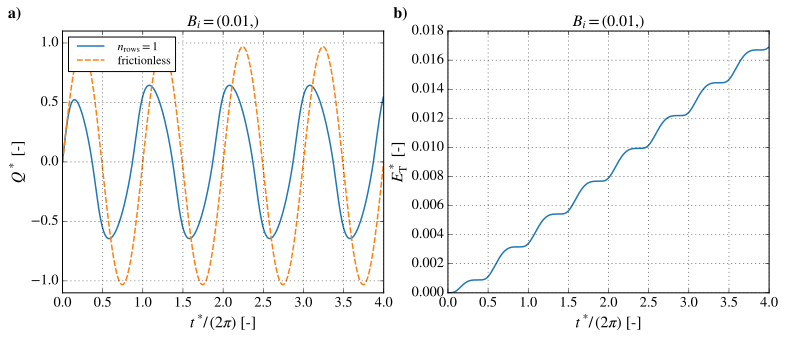

In [10]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
fig.subplots_adjust( wspace = 0.2 )

n_rows = len( cfg.B_per_row )

Q_star_frictionless = ys_lossless_vec[:,0]
Q_star = ys_vec[:,0]
E_star = ys_vec[:,1]

# left figure
ax1.plot( ts_vec/twopi, Q_star, label="$n_\mathrm{rows}=%i$" % (n_rows) )
ax1.plot( ts_vec/twopi, Q_star_frictionless, label="frictionless" )
ax1.grid()
ax1.set_title( "$B_i = $" + str( cfg.B_per_row ) )
ax1.set_xlim( ( 0, 4 ) )
ax1.set_ylim( ( -1.1, 1.1 ) )
ax1.set_xlabel( '$t^*\!/\,(2\pi)$ [-]')
ax1.set_ylabel( '$Q^*$ [-]')
ax1.text(-0.17, 1.05, 'a)', transform=ax1.transAxes, size=16, weight='semibold')
ax1.legend( loc='upper left', fontsize=12, handlelength=2.9,labelspacing=0.25)

# right figure
ax2.plot( ts_vec/twopi, E_star )
ax2.grid()
ax2.set_title( "$B_i = %4.2f$" + str( cfg.B_per_row ) )
ax2.set_xlim( ( 0, 4 ) )
ax2.set_xlabel( '$t^*\!/\,(2\pi)$ [-]')
ax2.set_ylabel( '$E_\mathrm{T}^*$ [-]')
ax2.text(-0.17, 1.05, 'b)', transform=ax2.transAxes, size=16, weight='semibold');

mpl.savefig( 'Friction_model.pdf', bbox_inches='tight', pad_inches=0.02);